In [70]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from pathlib import Path
import re
from skimage import measure
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import matplotlib as mpl
import tqdm
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [71]:
images_path = "/Users/ciro/Documents/dataset"
masks_path = "/Users/ciro/Documents/dataset"

## Load and Preprocess Data

Load the 3D MRI images and masks, normalize the images, and binarize them.


In [74]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import morphology

limit = 300
images = []
masks = []

def load_nii(file_path):
    """Load a NIfTI file."""
    return nib.load(file_path).get_fdata()

def get_images_and_masks(grade):
    grade_dir = os.path.join(images_path, grade)
    all_files = [imgname for imgname in os.listdir(grade_dir) if imgname != ".DS_Store"]
    sampled_files = random.sample(all_files, min(limit, len(all_files)))

    for imgname in sampled_files:
        modalities = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        image_paths = [os.path.join(grade_dir, imgname, f"{imgname}{modality}") for modality in modalities]
        mask_path = os.path.join(grade_dir, imgname, f"{imgname}_seg.nii")
        images.append(image_paths)
        masks.append(mask_path)

get_images_and_masks('HGG')
get_images_and_masks('LGG')

print("Number of image sets loaded:", len(images))
print("Number of masks loaded:", len(masks))

def normalize_image(image):
    return (image - np.mean(image)) / np.std(image)

def binarize_image(image, threshold):
    return (image > threshold).astype(np.uint8)

def preprocess_images(image_paths):
    modalities = ['flair', 't1', 't1ce', 't2']
    images = {modality: normalize_image(load_nii(image_paths[i])) for i, modality in enumerate(modalities)}
    thresholds = {'flair': 0.7, 't2': 0.7, 't1ce': 0.9}
    binary_images = {modality: binarize_image(images[modality], thresholds[modality]) for modality in thresholds}
    combined_binary = np.logical_and(binary_images['flair'], binary_images['t2']).astype(np.uint8)
    return combined_binary


Number of image sets loaded: 335
Number of masks loaded: 335


## Select the Best Slice

Use the slice selection method described in the articles to choose the best slice.

In [75]:
def select_best_slice(binary_image):
    slice_scores = [np.sum(binary_image[:, :, i]) for i in range(binary_image.shape[2])]
    best_slice = np.argmax(slice_scores)
    return best_slice

best_slices = []
for i in range(len(images)):
    image_paths = images[i]
    mask_path = masks[i]

    # Preprocess images to get combined binary image
    binary_image = preprocess_images(image_paths)

    # Load and preprocess mask separately
    mask = load_nii(mask_path)
    binary_mask = binarize_image(mask, 0.5)  # Assuming mask threshold of 0.5 for binarization

    # Select best slice for the mask
    best_slice = select_best_slice(binary_mask)
    best_slices.append(best_slice)


## Visualize Selected Slices

Display the selected slices for five image sets.

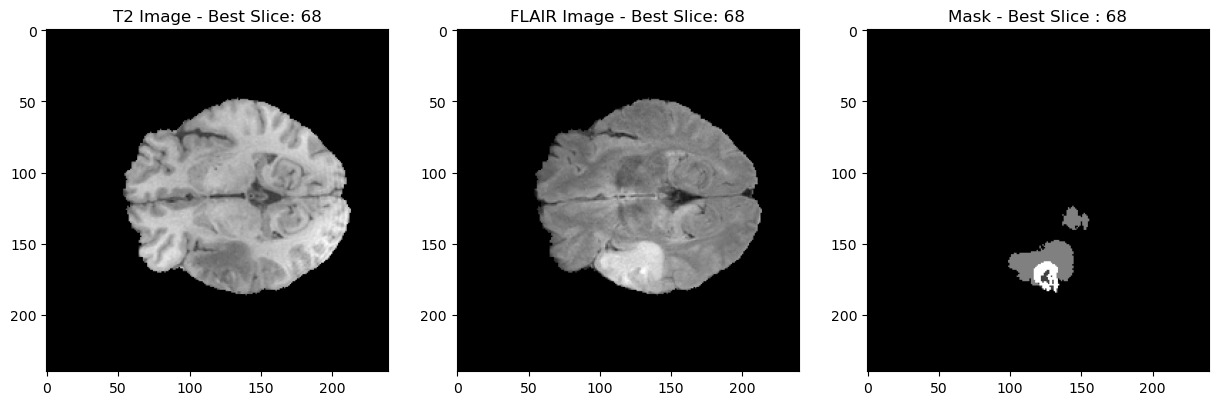

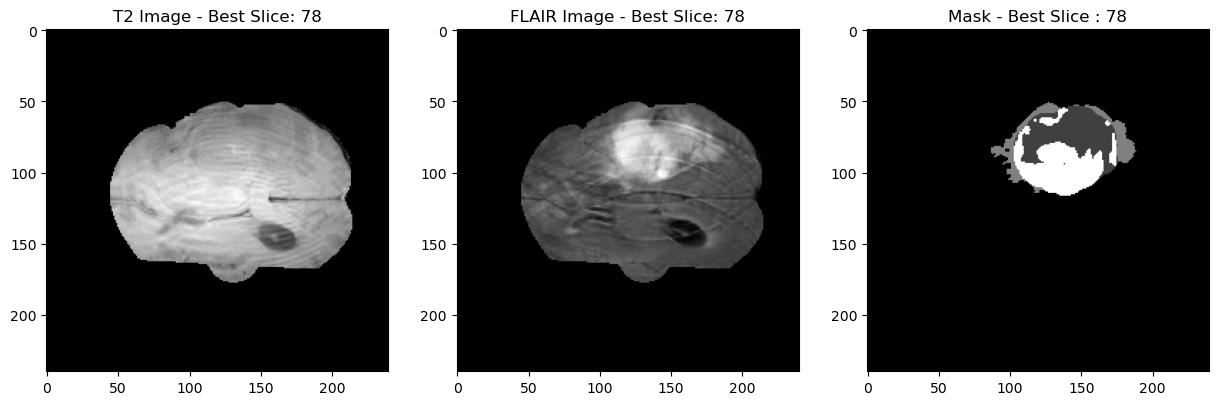

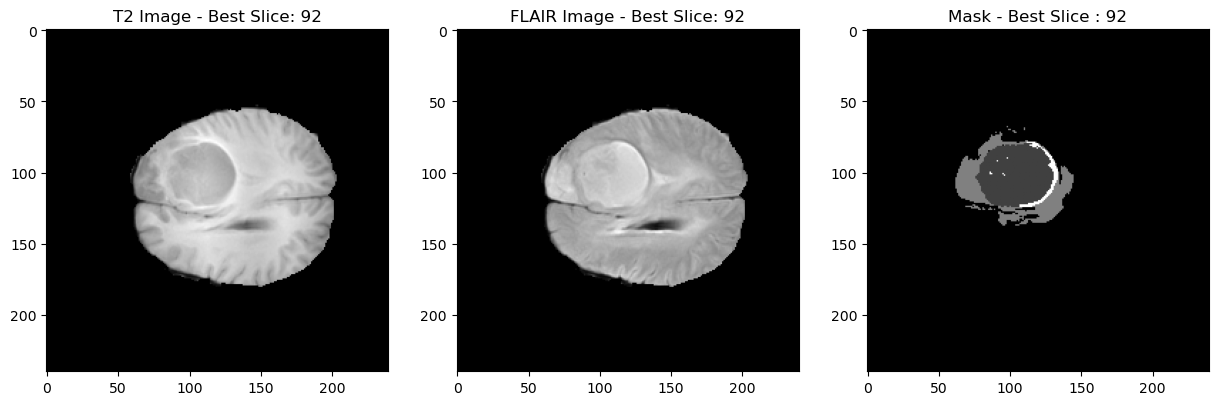

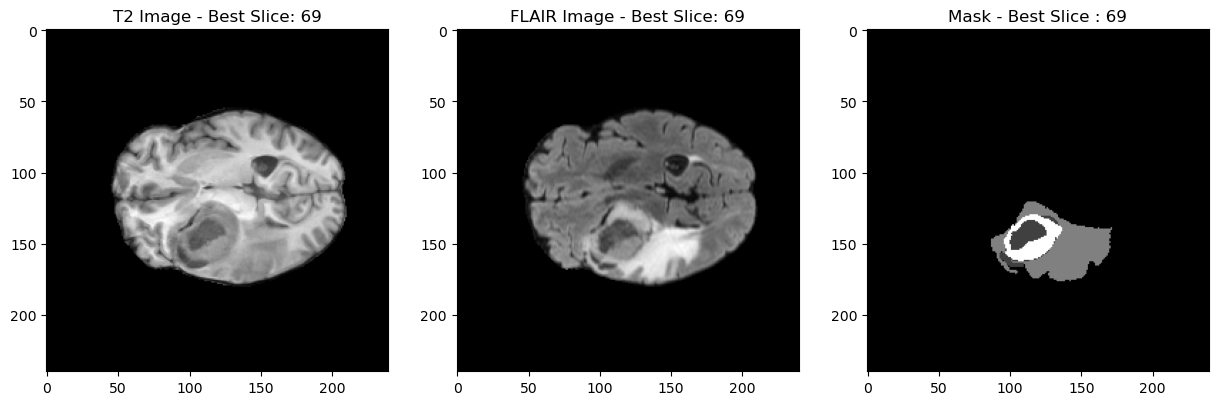

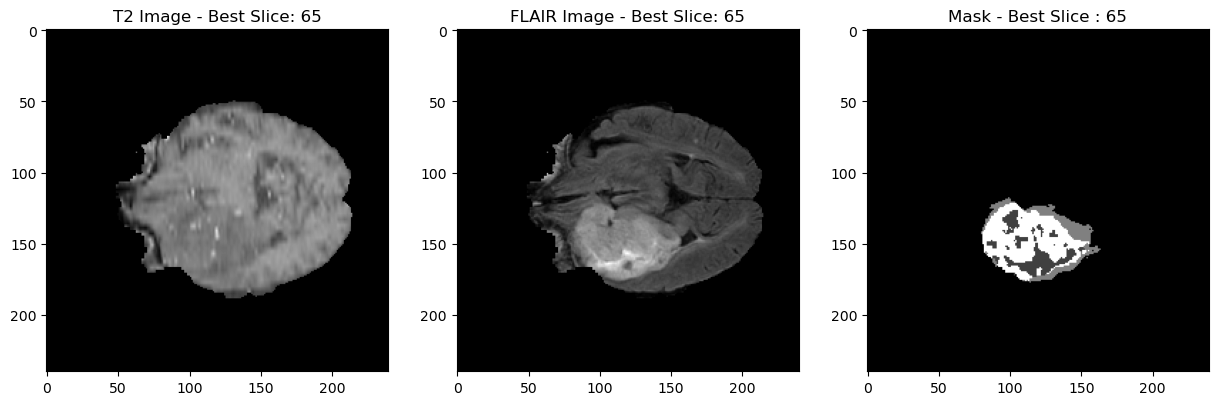

In [81]:

def visualize_slices(images, masks, best_slices, num_to_visualize=5):
    for i in range(min(num_to_visualize, len(images))):
        image_paths = images[i]
        mask_path = masks[i]
        best_slice = best_slices[i]
        
        flair_image = load_nii(image_paths[0])
        t2_image = load_nii(image_paths[1])
        mask = load_nii(mask_path)
        
        plt.figure(figsize=(15, 5))
       
        plt.subplot(1, 3, 1)
        plt.title(f'T2 Image - Best Slice: {best_slice}')
        plt.imshow(t2_image[:, :, best_slice], cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title(f"FLAIR Image - Best Slice: {best_slice}")
        plt.imshow(flair_image[:, :, best_slice], cmap='gray')

         
        

        plt.subplot(1, 3, 3)
        plt.title(f"Mask - Best Slice : {best_slice}")
        plt.imshow(mask[:, :, best_slice], cmap='gray')
        
        plt.show()

visualize_slices(images, masks, best_slices)



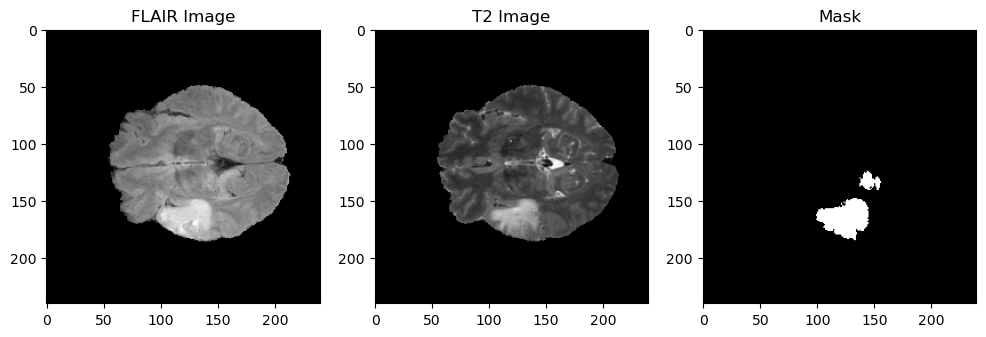

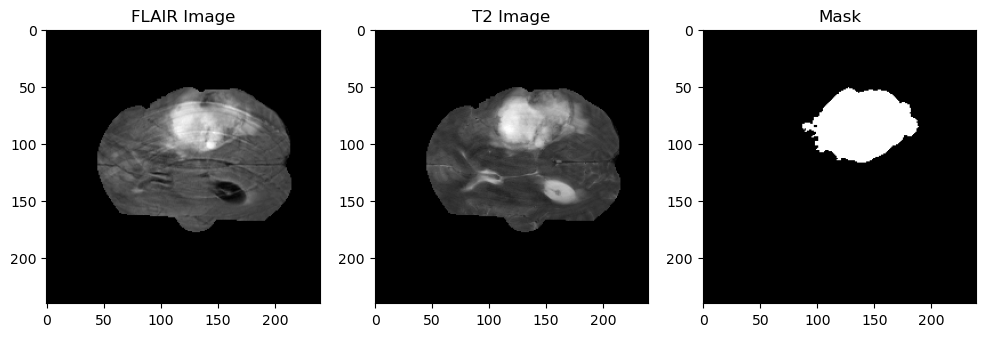

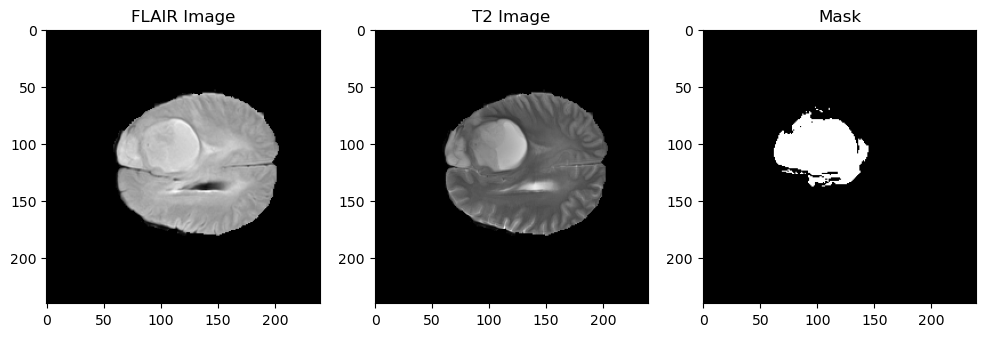

In [82]:
X = []
Y = []

for i in range(len(images)):
    image_paths = images[i]
    mask_path = masks[i]
    best_slice = best_slices[i]

    # Load images and select the best slice
    flair_image = load_nii(image_paths[0])[:, :, best_slice]
    t2_image = load_nii(image_paths[3])[:, :, best_slice]
    
    # Stack the selected modalities
    combined_image = np.stack((flair_image, t2_image), axis=-1)
    X.append(combined_image)
    
    # Load the mask and select the best slice
    mask = load_nii(mask_path)[:, :, best_slice]
    Y.append(mask)

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Normalize images and binarize masks
X = X / np.max(X)
Y = (Y > 0).astype(np.uint8)

# Visualize some examples to ensure data correctness
for i in range(3):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('FLAIR Image')
    plt.imshow(X[i, :, :, 0], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title('T2 Image')
    plt.imshow(X[i, :, :, 1], cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title('Mask')
    plt.imshow(Y[i], cmap='gray')
    
    plt.show()


## Define the U-Net Model
Define the U-Net architecture, ensuring it is suitable for processing the image slices.

In [83]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU

def unet(input_size=(256, 256, 2)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs, conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=[MeanIoU(num_classes=2)])
    
    return model

model = unet(input_size=(X.shape[1], X.shape[2], X.shape[3]))
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 240, 240,  │      1,216 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 240, 240,  │     36,928 │ conv2d_59[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 120, 120,  │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 120, 120,  │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 120, 120,  │    147,584 │ conv2d_61[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 60, 60,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 60, 60,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 60, 60,    │    590,080 │ conv2d_63[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 30, 30,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 30, 30,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 30, 30,    │  2,359,808 │ conv2d_65[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 30, 30,    │          0 │ conv2d_66[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 15, 15,    │          0 │ dropout_6[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 15, 15,    │  4,719,616 │ max_pooling2d_15… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 15, 15,    │  9,438,208 │ conv2d_67[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 15, 15,    │          0 │ conv2d_68[0][0] 

 Total params: 31,032,261 (118.38 MB)

 Trainable params: 31,032,261 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model
Train the model using the preprocessed images and masks. Implement callbacks for early stopping and model checkpointing.

In [84]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('unet_brain_tumor_segmentation2.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)



In [85]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=4, callbacks=[checkpoint, early_stopping])


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.5095 - mean_io_u_2: 0.4777
Epoch 1: val_loss improved from inf to 0.13543, saving model to unet_brain_tumor_segmentation2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - loss: 0.5068 - mean_io_u_2: 0.4777 - val_loss: 0.1354 - val_mean_io_u_2: 0.4792
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1176 - mean_io_u_2: 0.4775
Epoch 2: val_loss improved from 0.13543 to 0.10420, saving model to unet_brain_tumor_segmentation2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 352s 5s/step - loss: 0.1176 - mean_io_u_2: 0.4775 - val_loss: 0.1042 - val_mean_io_u_2: 0.4792
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.1036 - mean_io_u_2: 0.4777
Epoch 3: val_loss improved from 0.10420 to 0.10147, saving model to unet_brain_tumor_segmentation2.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - loss: 0.1036 - mean_io_u_2: 0.4777 - val_loss: 0.1015 - val_mean_io_u_2: 0.4792
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - loss: 0.0973 

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


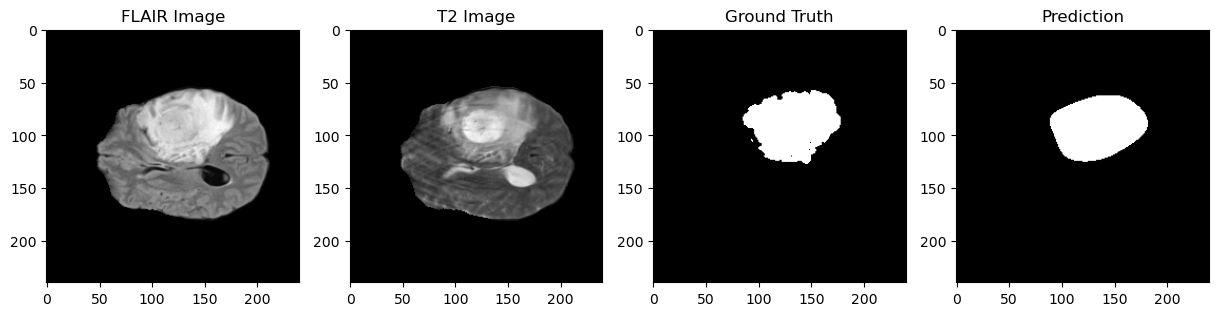

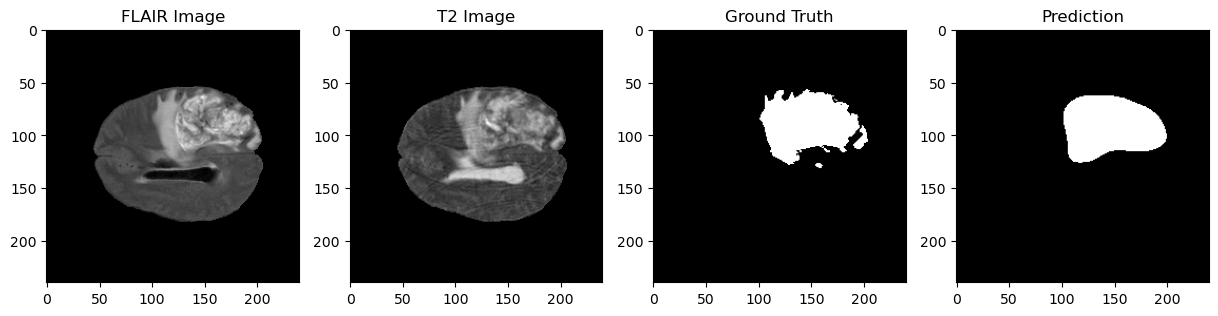

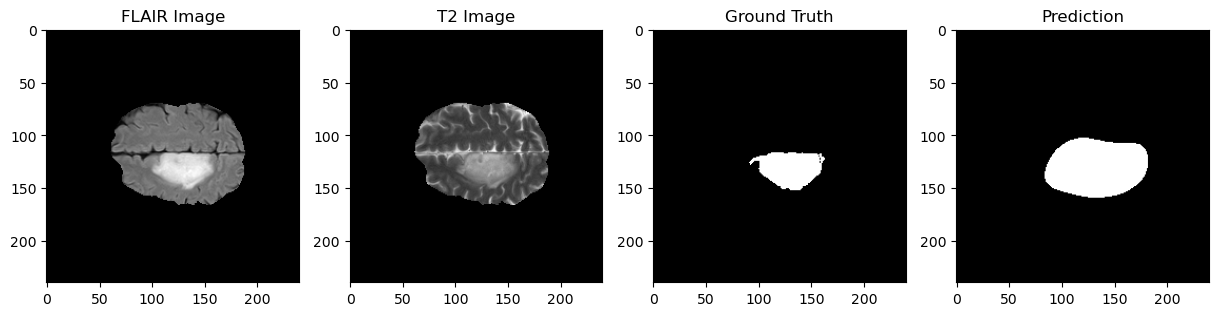

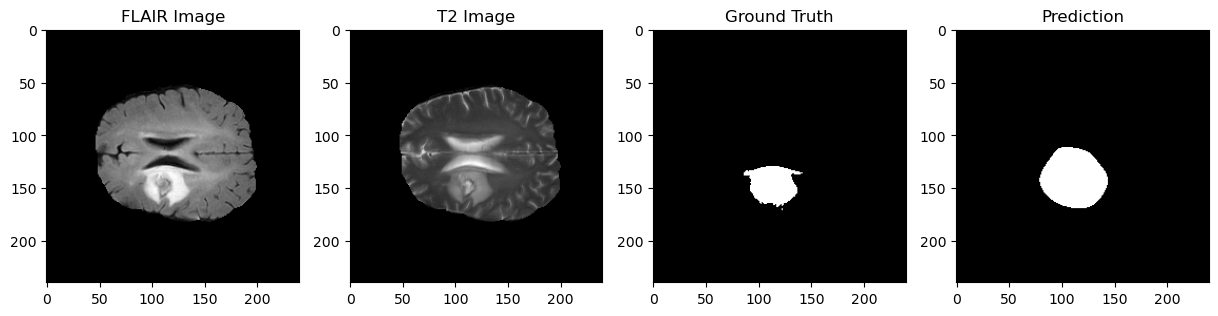

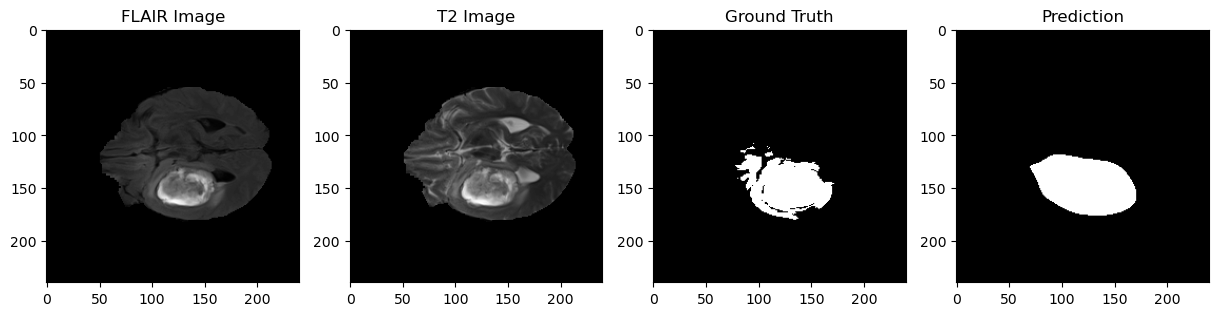

In [87]:
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)
num_images_to_show = 5
indices = np.random.choice(len(X_val), num_images_to_show, replace=False)

for idx in indices:
    plt.figure(figsize=(15, 5))
    
    # FLAIR image
    plt.subplot(1, 4, 1)
    plt.title('FLAIR Image')
    plt.imshow(X_val[idx, :, :, 0], cmap='gray')
    
    # T2 image
    plt.subplot(1, 4, 2)
    plt.title('T2 Image')
    plt.imshow(X_val[idx, :, :, 1], cmap='gray')
    
    # Ground Truth
    plt.subplot(1, 4, 3)
    plt.title('Ground Truth')
    plt.imshow(Y_val[idx], cmap='gray')
    
    # Prediction
    plt.subplot(1, 4, 4)
    plt.title('Prediction')
    plt.imshow(preds[idx, :, :, 0], cmap='gray')
    
    plt.show()


In [67]:
#modelLoaded=load_model('unet_brain_tumor_segmentation.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 0.0548 - mean_io_u_2: 0.4795
Validation Loss: 0.05685275420546532
Validation Mean IoU: 0.47923922538757324
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


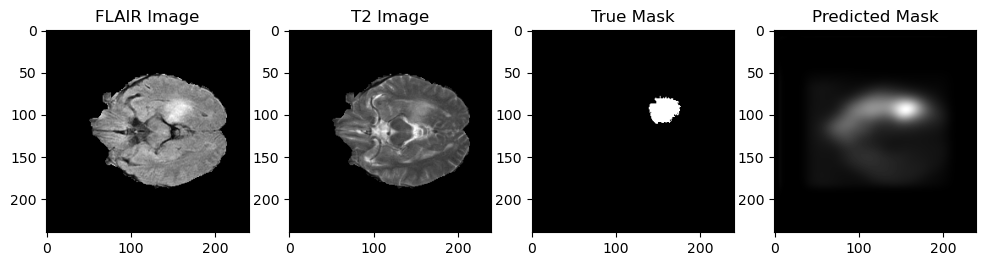

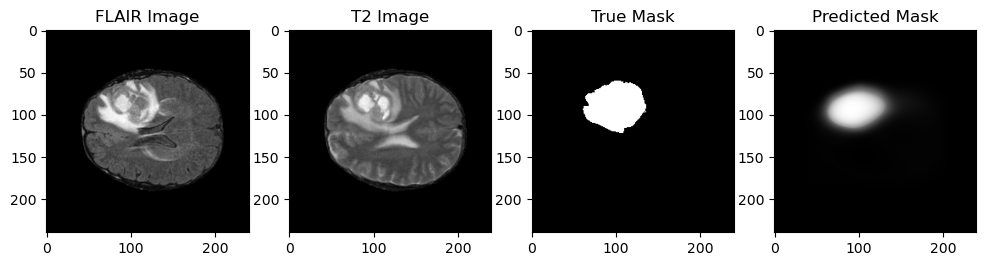

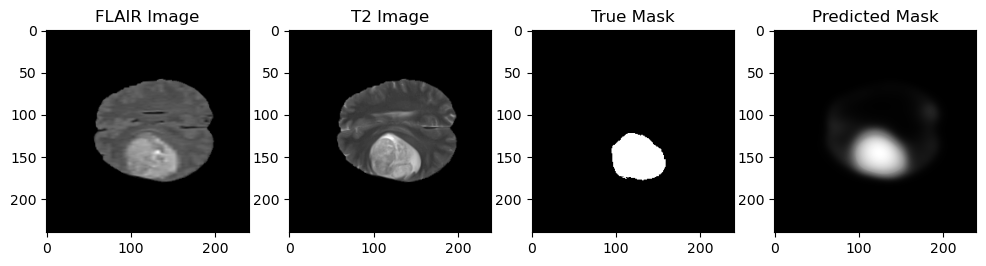

In [91]:
# Load the best model
model.load_weights('unet_brain_tumor_segmentation2.keras')

 
# Evaluate the model on the validation set
val_loss, val_miou = model.evaluate(X_val, Y_val)

print(f"Validation Loss: {val_loss}")
print(f"Validation Mean IoU: {val_miou}")

# Visualize predictions
preds = model.predict(X_val)

for i in range(3):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.title('FLAIR Image')
    plt.imshow(X_val[i, :, :, 0], cmap='gray')
    
    plt.subplot(1, 4, 2)
    plt.title('T2 Image')
    plt.imshow(X_val[i, :, :, 1], cmap='gray')
    
    plt.subplot(1, 4, 3)
    plt.title('True Mask')
    plt.imshow(Y_val[i], cmap='gray')
    
    plt.subplot(1, 4, 4)
    plt.title('Predicted Mask')
    plt.imshow(preds[i, :, :, 0], cmap='gray')
    
    plt.show()


# Data augmantation

Use ImageDataGenerator from Keras to perform data augmentation. Common augmentations include rotations, shifts, flips, and zooms.

In [113]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator with data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train, batch_size=8, seed=seed)
mask_generator = mask_datagen.flow(Y_train, batch_size=8, seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)


print("Original training data size:", X_train.shape)
print("Augmented training data size:", augmented_X_train.shape)


Original training data size: (268, 240, 240, 2)
Augmented training data size: (264, 240, 240, 2)


In [143]:
 

 
num_samples_to_match = len(Y_train)
augmented_Y_train_subset = augmented_Y_train[:num_samples_to_match]

final_Y_train = np.concatenate((Y_train, augmented_Y_train_subset), axis=0)

In [144]:
len(final_Y_train)

532

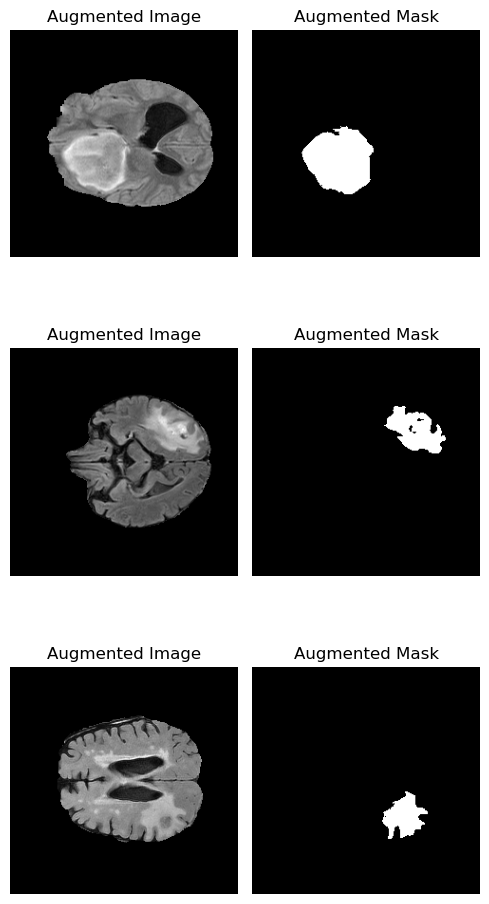

In [147]:
import matplotlib.pyplot as plt

# Fetch a batch of augmented images and masks
augmented_images, augmented_masks = next(train_generator)

# Plot the augmented images and masks
num_images_to_show = 3
fig, axes = plt.subplots(num_images_to_show, 2, figsize=(5, 10))

for i in range(num_images_to_show):
    # Display the augmented image
    axes[i, 0].imshow(final_X_train[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title('Augmented Image')
    axes[i, 0].axis('off')
    
    # Display the corresponding augmented mask
    axes[i, 1].imshow(final_Y_train[i, :, :, 0], cmap='gray')
    axes[i, 1].set_title('Augmented Mask')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


## Enhanced Model Architecture


In [ ]:
from tensorflow.keras.layers import BatchNormalization

def enhanced_unet(input_size=(256, 256, 2)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs, conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=[MeanIoU(num_classes=2)])
    
    return model

model = enhanced_unet(input_size=(256, 256, 2))
model.summary()


In [149]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('unet_brain_tumor_segmentation_plus_augmanted_data.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(final_X_train, final_Y_train, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=4, callbacks=[checkpoint, early_stopping])


Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.7156 - mean_io_u_3: 0.4945
Epoch 1: val_loss improved from inf to 0.68818, saving model to unet_brain_tumor_segmentation_plus_augmanted_data.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 591s 6s/step - loss: 0.7155 - mean_io_u_3: 0.4946 - val_loss: 0.6882 - val_mean_io_u_3: 0.4784
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.6808 - mean_io_u_3: 0.4915
Epoch 2: val_loss improved from 0.68818 to 0.68312, saving model to unet_brain_tumor_segmentation_plus_augmanted_data.keras
107/107 ━━━━━━━━━━━━━━━━━━━━ 581s 5s/step - loss: 0.6808 - mean_io_u_3: 0.4915 - val_loss: 0.6831 - val_mean_io_u_3: 0.4784
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.6722 - mean_io_u_3: 0.4877
Epoch 3: val_loss did not improve from 0.68312
107/107 ━━━━━━━━━━━━━━━━━━━━ 587s 5s/step - loss: 0.6721 - mean_io_u_3: 0.4877 - val_loss: 0.6973 - val_mean_io_u_3: 0.4857
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.6687 - mean_

4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 9s/step


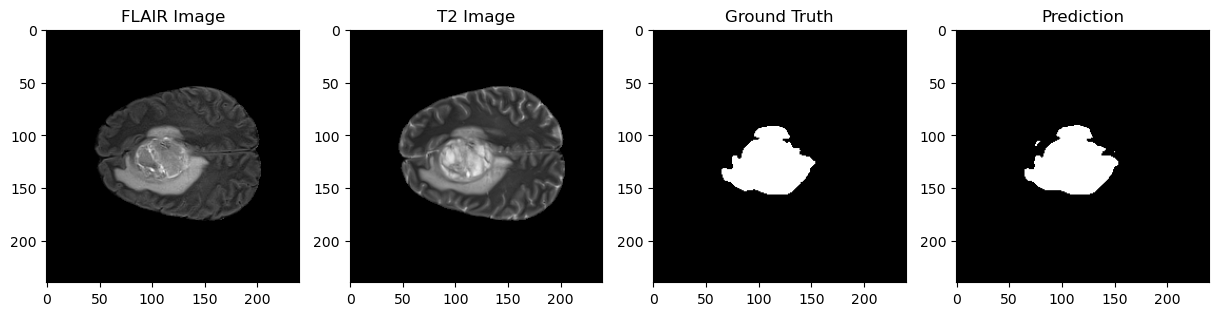

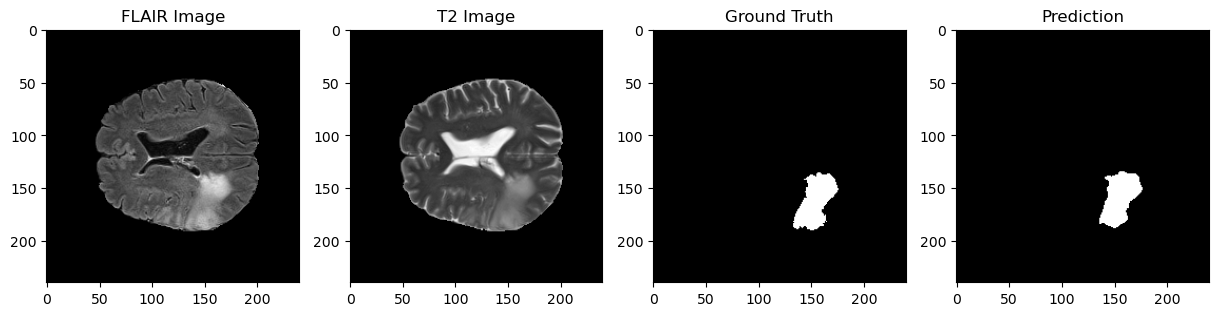

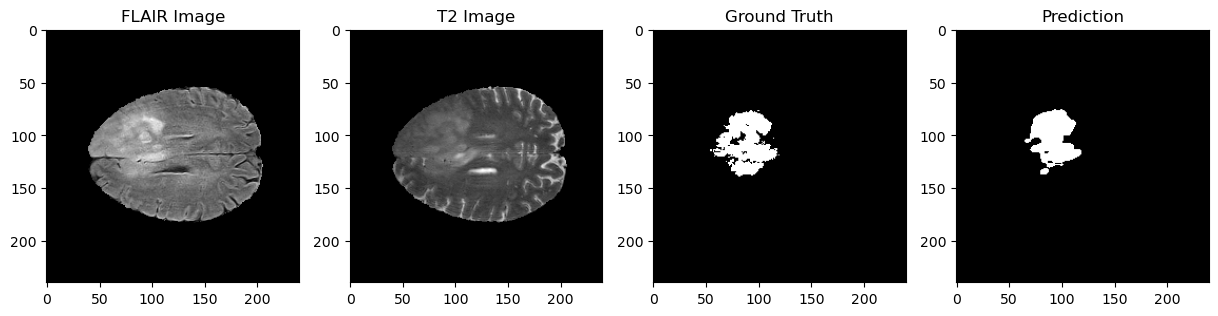

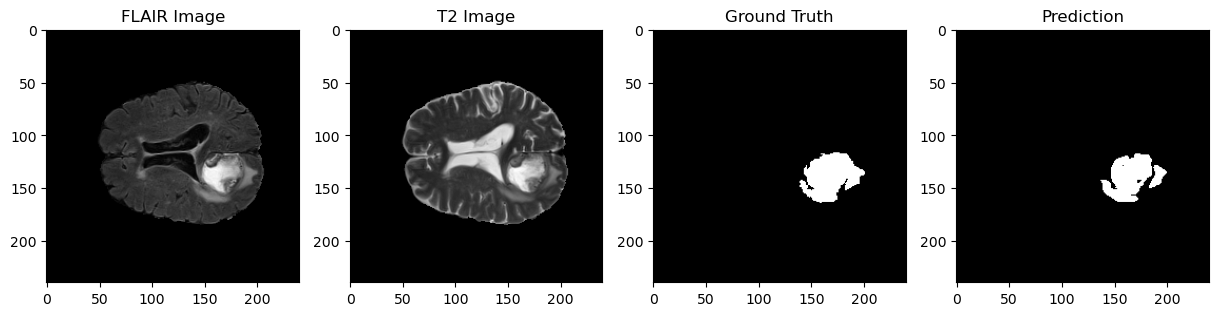

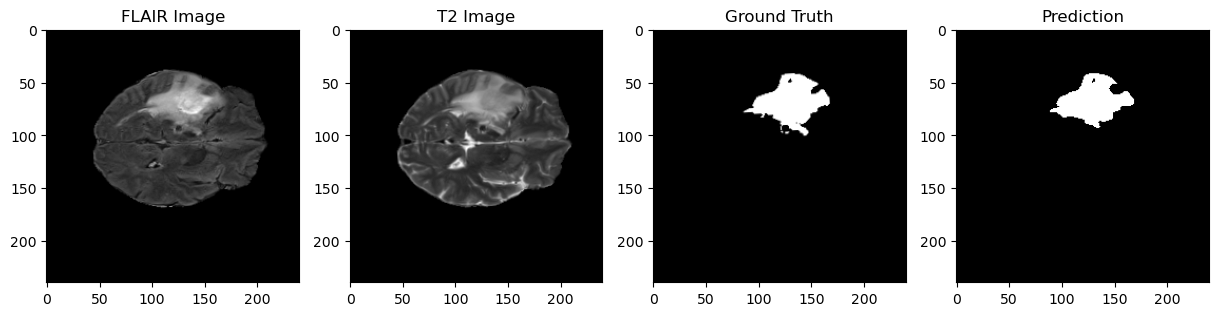

In [175]:
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)
num_images_to_show = 5
indices = np.random.choice(len(X_val), num_images_to_show, replace=False)

for idx in indices:
    plt.figure(figsize=(15, 5))
    
    # FLAIR image
    plt.subplot(1, 4, 1)
    plt.title('FLAIR Image')
    plt.imshow(X_val[idx, :, :, 0], cmap='gray')
    
    # T2 image
    plt.subplot(1, 4, 2)
    plt.title('T2 Image')
    plt.imshow(X_val[idx, :, :, 1], cmap='gray')
    
    # Ground Truth
    plt.subplot(1, 4, 3)
    plt.title('Ground Truth')
    plt.imshow(Y_val[idx], cmap='gray')
    
    # Prediction
    plt.subplot(1, 4, 4)
    plt.title('Prediction')
    plt.imshow(preds[idx, :, :, 0], cmap='gray')
    
    plt.show()

    


In [167]:
 
from sklearn.metrics import precision_score, recall_score, f1_score
 

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def evaluate_metrics(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    dice = dice_coefficient(y_true, y_pred)
    precision = precision_score(y_true_f, y_pred_f)
    recall = recall_score(y_true_f, y_pred_f)
    f1 = f1_score(y_true_f, y_pred_f)
    return dice, precision, recall, f1

# Make predictions
Y_pred = model.predict(X_val)

# Binarize predictions
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)
Y_val_binary = (Y_val > 0.5).astype(np.uint8)

# Evaluate the metrics
dice_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i in range(len(Y_val_binary)):
    y_true = Y_val_binary[i]
    y_pred = Y_pred_binary[i]
    dice, precision, recall, f1 = evaluate_metrics(y_true, y_pred)
    dice_scores.append(dice)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

avg_dice = np.mean(dice_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f'Average Dice Coefficient: {avg_dice}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Dice Coefficient: 0.8380877935970479
Average Precision: 0.9108297877285231
Average Recall: 0.8130084357007493
Average F1 Score: 0.8380877935339873


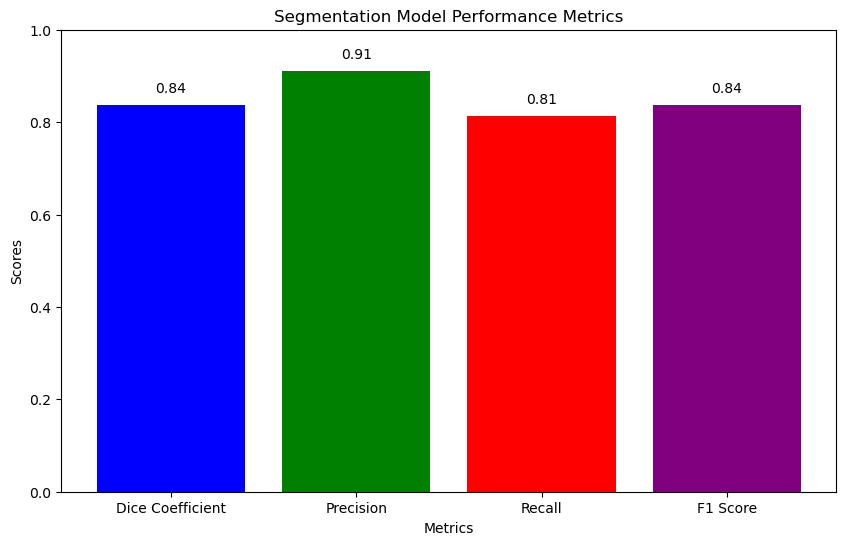

In [168]:



# Metrics names and values
metrics = ['Dice Coefficient', 'Precision', 'Recall', 'F1 Score']
values = [avg_dice, avg_precision, avg_recall, avg_f1]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.title('Segmentation Model Performance Metrics')
plt.ylabel('Scores')
plt.xlabel('Metrics')

# Annotating the bars with the values
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()


To improve >>>>>>>>


## Hyperparameter Tuning
You'll need to create a function to build your model, where you specify the hyperparameters you want to tune. For example, tuning the number of filters in each convolutional layer and the dropout rate

In [118]:

def build_model(hp):
    inputs = Input((256, 256, 2))

    # Encoder
    conv1 = Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=16), 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=16), 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=32), 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=32), 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=64), 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=64), 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(hp.Int('conv4_filters', min_value=256, max_value=1024, step=128), 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(hp.Int('conv4_filters', min_value=256, max_value=1024, step=128), 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1))(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(hp.Int('conv5_filters', min_value=512, max_value=2048, step=256), 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(hp.Int('conv5_filters', min_value=512, max_value=2048, step=256), 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1))(conv5)

    # Decoder
    up6 = Conv2D(hp.Int('conv4_filters', min_value=256, max_value=1024, step=128), 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(hp.Int('conv4_filters', min_value=256, max_value=1024, step=128), 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(hp.Int('conv4_filters', min_value=256, max_value=1024, step=128), 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=64), 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=64), 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=64), 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=32), 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=32), 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=32), 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=16), 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=16), 3, activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=16), 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])),
                  loss=binary_crossentropy,
                  metrics=[MeanIoU(num_classes=2)])

    return model


In [126]:
import numpy as np
from skimage.transform import resize

def preprocess_and_resize(images, masks, target_size=(256, 256)):
    X_resized = np.zeros((len(images), target_size[0], target_size[1], 2), dtype=np.float32)
    Y_resized = np.zeros((len(masks), target_size[0], target_size[1]), dtype=np.float32)

    for i in range(len(images)):
        flair = images[i][:, :, 0]
        t2 = images[i][:, :, 1]
        
        # Resize images
        flair_resized = resize(flair, target_size, mode='constant', preserve_range=True)
        t2_resized = resize(t2, target_size, mode='constant', preserve_range=True)
        X_resized[i, :, :, 0] = flair_resized
        X_resized[i, :, :, 1] = t2_resized

        # Resize masks
        mask_resized = resize(masks[i], target_size, mode='constant', preserve_range=True)
        Y_resized[i, :, :] = np.squeeze(mask_resized)

    return X_resized, Y_resized

X_train_resized, Y_train_resized = preprocess_and_resize(X_train, Y_train)
X_val_resized, Y_val_resized = preprocess_and_resize(X_val, Y_val)


# Set up tunner

In [132]:
from tensorflow.keras.metrics import MeanIoU

num_classes = 2  # Binary segmentation (tumor and non-tumor)
mean_iou_metric = MeanIoU(num_classes=num_classes)


In [133]:
import keras_tuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='brain_tumor_segmentation'
)


Reloading Tuner from my_dir/brain_tumor_segmentation/tuner0.json


Run the Tuning:
Run the hyperparameter tuning process.

In [134]:
tuner.search(X_train_resized, Y_train_resized,
             epochs=1,
             validation_data=(X_val_resized, Y_val_resized))



Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
80                |96                |conv1_filters
192               |96                |conv2_filters
128               |512               |conv3_filters
896               |512               |conv4_filters
0.4               |0.5               |dropout_rate
2048              |1792              |conv5_filters
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 1451s 155s/step - loss: 0.2967 - mean_io_u: 0.4792 - val_loss: 0.7039 - val_mean_io_u: 0.4808
Epoch 2/2
9/9 ━━━━━━━━━━━━━━━━━━━━ 1311s 142s/step - loss: 0.1333 - mean_io_u: 0.4788 - val_loss: 0.8649 - val_mean_io_u: 0.4808


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py", line 718, in deserialize_keras_object
    instance = cls.from_config(inner_config)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/metrics/metric.py", line 228, in from_config
    return cls(**config)
           ^^^^^^^^^^^^^
TypeError: MeanIoU.__init__() missing 1 required positional argument: 'num_classes'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 261, in _run_and_update_trial
    self.oracle.update_trial(
  File "/opt/anaconda3/lib/python3.11/site-package

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py", line 718, in deserialize_keras_object
    instance = cls.from_config(inner_config)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/metrics/metric.py", line 228, in from_config
    return cls(**config)
           ^^^^^^^^^^^^^
TypeError: MeanIoU.__init__() missing 1 required positional argument: 'num_classes'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 261, in _run_and_update_trial
    self.oracle.update_trial(
  File "/opt/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/oracle.py", line 108, in wrapped_func
    ret_val = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/oracle.py", line 529, in update_trial
    trial.metrics.register(metric_name, direction=direction)
  File "/opt/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/metrics_tracking.py", line 214, in register
    direction = infer_metric_direction(name)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/metrics_tracking.py", line 354, in infer_metric_direction
    metric = keras.metrics.deserialize(  # pragma: no cover
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/metrics/__init__.py", line 155, in deserialize
    return serialization_lib.deserialize_keras_object(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py", line 581, in deserialize_keras_object
    return deserialize_keras_object(
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py", line 720, in deserialize_keras_object
    raise TypeError(
TypeError: <class 'keras.src.metrics.iou_metrics.MeanIoU'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.metrics', 'class_name': 'MeanIoU', 'config': None, 'registered_name': None}.

Exception encountered: MeanIoU.__init__() missing 1 required positional argument: 'num_classes'


Get the Best Hyperparameters:
Retrieve the best hyperparameters found by the tuner.

In [135]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is {best_hps.get('conv1_filters')}, 
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')},
and the optimal dropout rate is {best_hps.get('dropout_rate')}.
""")



The hyperparameter search is complete. The optimal number of filters in the first convolutional layer is 96, 
the optimal learning rate for the optimizer is 0.001,
and the optimal dropout rate is 0.5.



In [137]:




# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train_resized) // 8,
                    epochs=30,
                    validation_data=val_gen,
                    validation_steps=len(X_val_resized) // 8,
                    callbacks=[checkpoint])


NameError: name 'val_gen' is not defined

4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 8s/step


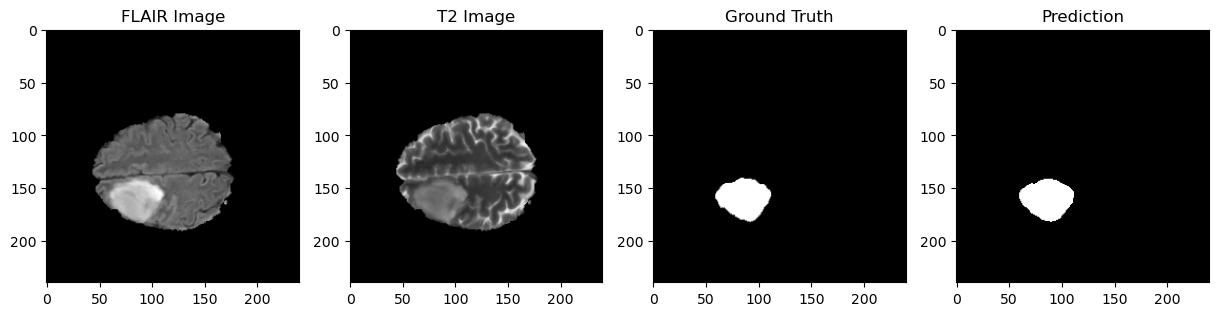

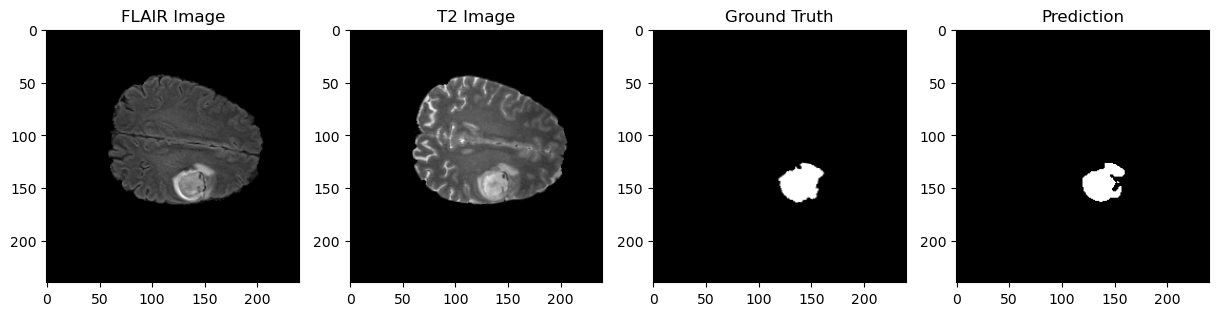

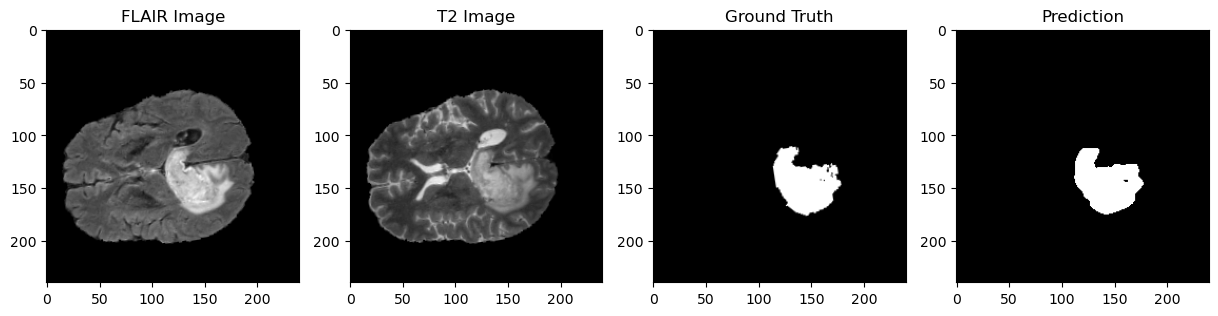

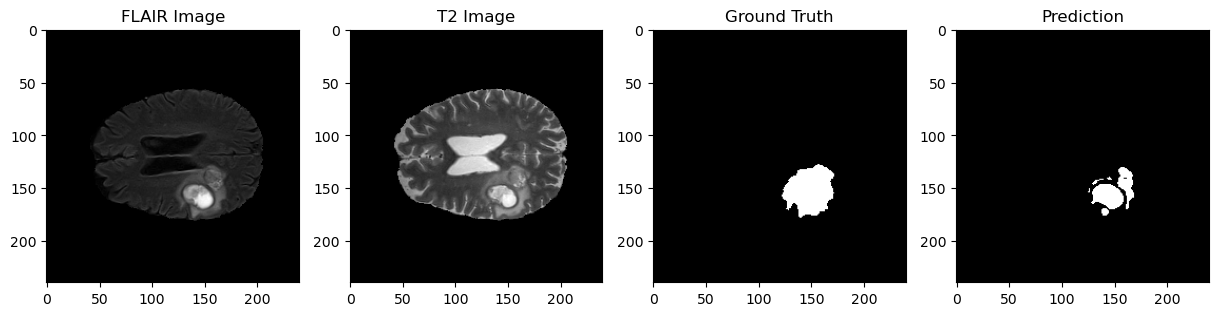

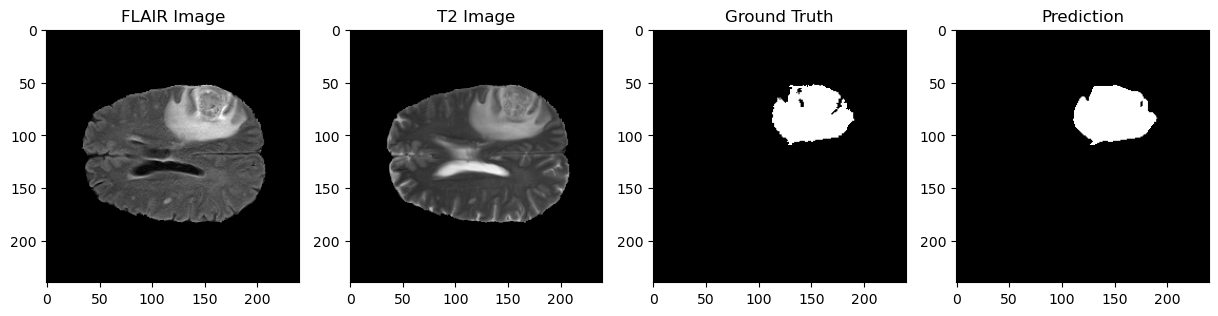

In [108]:
import cv2

def post_process_mask(mask):
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

# Apply post-processing to the predictions
processed_preds = np.array([post_process_mask(pred) for pred in preds])


In [18]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import morphology

import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage 


## Apply Data Augmentation
Let's augment the images and masks:

In [22]:
model.load_weights('unet_brain_tumor_segmentation.keras')
val_loss, val_iou = model.evaluate(X_val, Y_val, verbose=1)
print(f"Validation Loss: {val_loss}, Validation Mean IoU: {val_iou}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step - loss: 0.0433 - mean_io_u: 0.4769
Validation Loss: 0.043129563331604004, Validation Mean IoU: 0.4767521619796753
